In [142]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft, ifft
import sounddevice as sd
import librosa, soundfile as sf
#from scipy.signal import hann


### 1. Implementing the ADSR Envelope (0.5 points)

#### <font color='#A52A2A'> Process Explanation

We first create a synthesized signal to produce an artificial sound signal, and then we use the **envelope function** to make the sound more natural, giving it a starting point, an ending point, and changing its energy level over time.

**Envelope Function**

ADSR is a set of four parameters—Attack, Decay, Sustain, and Release—that control the amplitude (volume) of a sound over time, shaping its envelope from beginning to end. The four stages of ADSR: 
* Attack: The time it takes for the sound to go from silence to its peak volume after a key is pressed.
* Decay: The time it takes for the sound to drop from its peak volume to the sustain level.
* Sustain: The volume level the sound is held at while the key is being pressed. This is a level, not a time, and determines the sound's body.
* Release: The time it takes for the sound to fade to silence after the key is released.

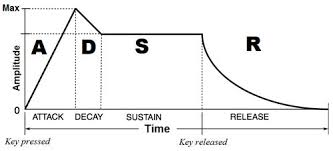

In [143]:
def plot_signal(t, x):
    """
    Plots the given signal x against time t.
    
    Parameters:
    - t: Time vector
    - x: Signal (either original or enveloped)
    """
    plt.figure(figsize=(10, 4))
    plt.plot(t, x)
    plt.title("Signal vs Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
def plot_envelope(t_env, env):
    """
    Plots the ADSR envelope against time t_env.
    
    Parameters:
    - t_env: Time vector for the ADSR envelope
    - env: ADSR envelope values
    """
    plt.figure(figsize=(10, 4))
    plt.plot(t_env, env)
    plt.title("ADSR Envelope vs Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Envelope Amplitude")
    plt.grid(True)
    plt.show()
    


## Taask 1.1 : Implement the ADSR envelope function

In [144]:
# Function to create ADSR envelope
def envelope(a, d, s, sd, r, fs):
    # a: Attack duration (seconds)
    # d: Decay duration (seconds)
    # s: Sustain level (range [0,1])
    # sd: Sustain duration (seconds)
    # r: Release duration (seconds)
    # fs: Sampling frequency (Hz)

    # Step 1: Generate time vector for the Attack phase
    # Create a time vector 't_attack' from 0 to 'a' seconds, with step size 1/fs
    # Generate envelope 'env_attack' linearly from 0 to 1 for the attack phase
    
    t_attack =  np.arange(0, a, 1/fs) 
    env_attack =  t_attack/a 

    # Step 2: Generate time vector for the Decay phase
    # Create a time vector 't_decay' from 'a' to 'a + d' seconds, with step size 1/fs
    # Generate envelope 'env_decay' linearly from 1 to sustain level 's' for the decay phase

    t_decay =  np.arange(a, a+d, 1/fs) 
    env_decay =  1 + (s - 1) * (t_decay - a) / d  

    # Step 3: Generate time vector for the Sustain phase
    # Create a time vector 't_sustain' from 'a + d' to 'a + d + sd' seconds, with step size 1/fs
    # Generate envelope 'env_sustain' with a constant value 's' for the sustain phase

    t_sustain =   np.arange(a + d, a + d + sd, 1/fs)
    env_sustain =  s * np.ones(len(t_sustain))

    # Step 4: Generate time vector for the Release phase
    # Create a time vector 't_release' from 'a + d + sd' to 'a + d + sd + r' seconds, with step size 1/fs
    # Generate envelope 'env_release' linearly from sustain level 's' to 0 for the release phase

    t_release =  np.arange(a + d + sd, a + d + sd + r, 1/fs)
    env_release =  s * (1 - (t_release - (a + d + sd)) / r)

    # Step 5: Concatenate all parts into the final time vector and envelope
    # Concatenate the time vectors t_attack, t_decay, t_sustain, t_release into a final time vector 't_env'
    # Concatenate the envelope parts env_attack, env_decay, env_sustain, env_release into the final envelope 'env'
    
    t_env =  np.concatenate([t_attack, t_decay, t_sustain, t_release])
    env =  np.concatenate([env_attack, env_decay, env_sustain, env_release])

    # Return the final time vector and ADSR envelope
    return t_env, env


## Task 1.2 : Implement synthesized signal function

In [145]:
# Function to generate synthesized signal x(t) using harmonics
def synthesize_signal(f0, N, fs, duration):
    # f0: Fundamental frequency (Hz)
    # N: Number of harmonics
    # fs: Sampling frequency (Hz)
    # duration: Duration of the signal (seconds)

    # Step 1: Generate the time vector for the signal
    # Create a time vector 't' from 0 to 'duration' seconds, with step size 1/fs
    
    t =  np.arange(0, duration, 1/fs)
    
    # Step 2: Initialize the signal as an array of zeros
    # Initialize 'x_t' with zeros having the same length as 't'
    x_t = np.zeros(len(t))

    # Step 3: For each harmonic k, generate a sine wave and add it to the signal
    for k in range(1, N + 1):  # Loop from k = 1 to N to generate harmonics and add them to 'x_t'
        a_k = np.random.rand()  # Generate a random amplitude 'a_k' for the k-th harmonic
        phi_k =  2 * np.pi * np.random.rand() # Generate a random phase 'phi_k' for the k-th harmonic

        harmonic = a_k * np.sin(2 * np.pi * k * f0 * t + phi_k)
        x_t = x_t + harmonic  # Add the k-th harmonic sine wave to the signal 'x_t'

    # Step 4: Return the time vector and the synthesized signal
    return t, x_t



## Task 1.3: generate ADSR envelope and plot it

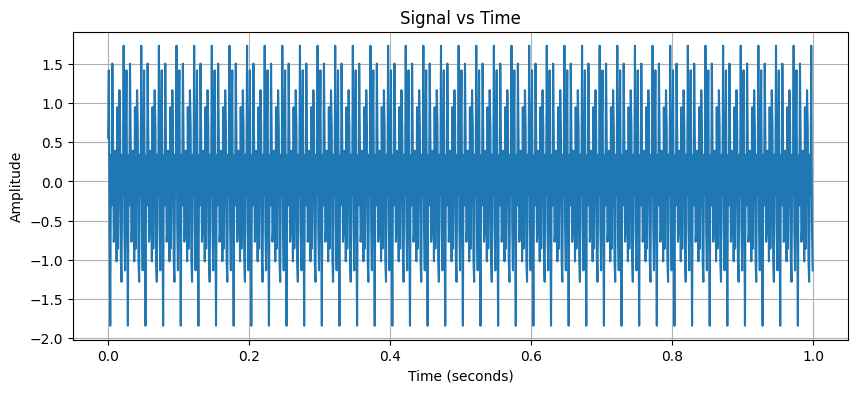

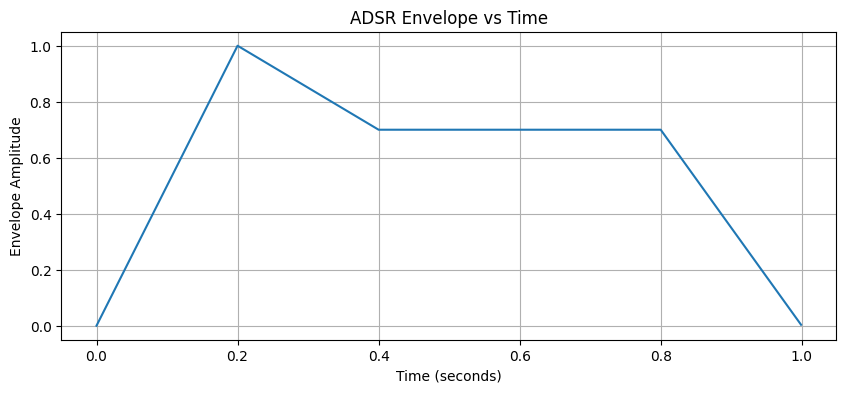

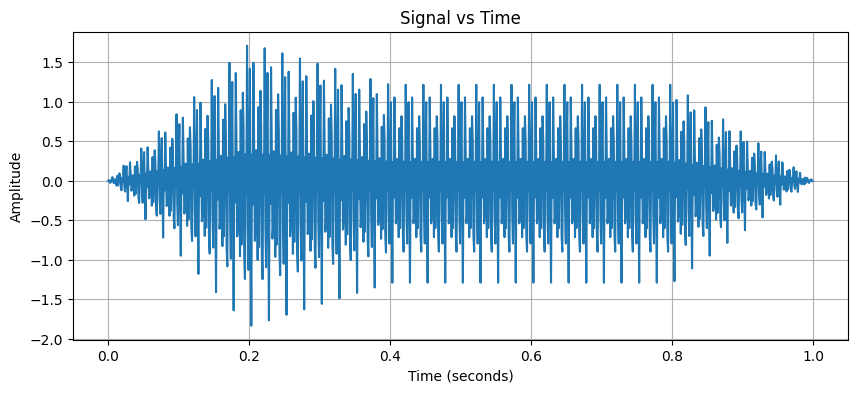

In [146]:
# Main Program to Implement ADSR and Synthesized Signal
# Step 1: Define the fundamental frequency and number of harmonics
f0 =   440 # A4 note fundamental frequency 
N = 5  # Number of harmonics to use 

# Step 2: Define the sampling frequency and duration
fs =  1000 # Sampling frequency (samples per second)
duration = 1  # Duration of the signal in seconds

# Step 3: Generate the synthesized signal x(t)
t, x = synthesize_signal(f0, N, fs, duration)

# Step 4: Define the ADSR parameters (a, d, s, sd, r)
a = 0.2  # Attack duration in seconds
d = 0.2  # Decay duration in seconds
s = 0.7  # Sustain level (0 to 1)
sd = 0.4  # Sustain duration in seconds
r = 0.2  # Release duration in seconds

# Step 5: Generate the ADSR envelope
t_env, env = envelope(a, d, s, sd, r, fs)

# Step 6: Apply the ADSR envelope to the synthesized signal
if len(env) > len(x):
    env = env[:len(x)]  # Trim envelope if longer than signal
elif len(env) < len(x):
    # Extend envelope with zeros if shorter than signal
    env_extended = np.zeros(len(x))
    env_extended[:len(env)] = env
    env = env_extended

x_enveloped = x * env # Multiply the original signal 'x' by the envelope 'env' to get the enveloped signal 'x_enveloped'

# Step 7: Plot the original signal, ADSR envelope, and the enveloped signal
plot_signal(t, x)  # Plot the original synthesized signal
plot_envelope(t_env, env)  # Plot the ADSR envelope
plot_signal(t, x_enveloped)  # Plot the enveloped signal


#### Auxiliary functions

In [147]:
def princarg(phase_in):
    """
    Computes principle argument,  wraps phase to (-pi, pi]
    """
    phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
    return phase
  

def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi

### 2. Implement a time stretching algorithm using phase vocoder. (1.5 points)

#### <font color='#A52A2A'> Process Explanation

The purpose of this section is to change speech speed without altering pitch. This capability is useful for applications such as adjusting audiobook playback speed and time-stretching audio while preserving the original pitch characteristics.

We will implement a **phase vocoder**-based time scaling algorithm that maintains pitch integrity. For comparison, we will also test a simple resampling method (like the one Librosa provides) which changes both speed and pitch, and analyze the differences in output quality.


1. **Divide the signal into small overlapping frames:**  
   We work in short segments because real-world signals are not stationary. Overlapping ensures smooth transitions when we reconstruct.

2. **Adjust overlap spacing based on the time-stretch ratio (R):**  
   Different hops between analysis and synthesis determine how the audio duration changes.  
   \( R = \frac{hop_{syn}}{hop_{an}} \)

   - \( R > 1 \) → slower (output longer)  
   - \( R < 1 \) → faster (output shorter)

3. **Transform each frame to the frequency domain (FFT):**  
   The FFT gives us both magnitude (energy of each frequency) and phase (timing).  
   We need the phase evolution to reconstruct smooth sound when time changes.

4. **Compute phase differences between frames:**  
   \( expected = 2\pi \cdot k \cdot hop_{an} / N \) is the natural phase rotation for each frequency bin.  
   By scaling \( \Delta\phi \) by \( R \), we stretch or compress the temporal evolution of phase.  
   This keeps frequencies coherent when time changes.

5. **Reconstruct each frame:**  
   We keep the same magnitudes but use updated phases → this changes the timing of wave cycles (duration) but not their rate (pitch).

6. **Overlap-Add (OLA) the frames:**  
   Combine overlapping frames smoothly using the synthesis window.  
   Without this, frames would cause amplitude jumps.

7. **Normalize:**  
   Normalize by the sum of window squares to restore consistent amplitude across overlapped regions.


#### <font color='#A52A2A'> My Observation


In the phase vocoder method, we tried **𝑟 = 1.4 and r=1.4**; in both cases the pitch did not change.
But with resampling, we can clearly hear the pitch change along with the speed. 

Output length ≈ len(audioIn) × R

Also, in the plot, we can see how the **length of the frames changes**, but the **amplitude does not**.

In [41]:
   
# audioIn, fs = lb.load('audio.wav', sr=None)   # read audio

# audioOut = np.zeros(len(audioIn))      # placeholder for reconstructed audio
# wLen = int(0.032*fs)                   # window length
# #winAn = np.sqrt(hann(wLen, sym=False)) # analysis window
# winAn = np.sqrt(lb.filters.get_window('hann', wLen, fftbins=True))
# winSyn = winAn


# winHopAn = int(0.008*fs)             # Hop length or frame advance
# inInd = 0

# R = 1.8 #winHopSyn / winHopAn;

# while inInd< len(audioIn)-wLen:
#     # selct the frame and multiply with window function
#     frame = audioIn[inInd:inInd+wLen]* winAn 

#     # compute DFT
#     f = fft(frame)

#     # save magnitudes and phases
#     mag_f = np.abs(f)
#     phi0 = np.angle(f) 
#     if inInd == 0:
#         # First frame - initialize phases
#         delta_phi_vals = np.zeros(wLen)
#         phi_syn = np.zeros(wLen)
#     else:
#         # Compute phase difference between consecutive frames
#         delta_phi_vals = delta_phi(curr_phi_an, prev_phi_an)
        
#         # Compute synthesis phase: previous synthesis phase + R * delta_phi
#         phi_syn = prev_phi_syn + R * delta_phi_vals
        
#         # Wrap phase to [-pi, pi]
#         phi_syn = princarg(phi_syn)

#     ####################
#     # processing in spectral domain 
#     #######################

#     # Recover the complex FFT back
#     ft = (abs(f)* np.exp(1j*phi0))  

#     # inverse DFT and windowing
#     frame = np.real(ifft(ft))*winSyn

#     # Ovelap add
#     audioOut[inInd :inInd +wLen] =  audioOut[inInd :inInd +wLen] + frame

#     # frame advance by winHopAn
#     inInd = inInd + winHopAn

In [151]:
audioIn, fs = lb.load('audio.wav', sr=None)
t = np.linspace(0, 0.1, int(0.1*fs))

In [164]:
def phase_vocoder(r, audioIn, fs):
    # frame parameters
    wLen = int(0.032 * fs)
    hop_an = int(0.008 * fs)

    # defining the window
    winAn = np.sqrt(lb.filters.get_window('hann', wLen, fftbins=True))
    winSyn = winAn.copy()

    # time ratio
    R = r
    hop_syn = int(np.round(R * hop_an))

    # estimate output length
    num_frames = 1 + (len(audioIn) - wLen) // hop_an if len(audioIn) >= wLen else 0
    outLen = int(num_frames * hop_syn + wLen)
    audioOut = np.zeros(max(outLen, len(audioIn)))
    ola_weight = np.zeros_like(audioOut)

    # phase variables
    prev_phi_an = np.zeros(wLen)
    prev_phi_syn = np.zeros(wLen)
    inInd = 0
    outInd = 0

    # processing loop
    while inInd + wLen <= len(audioIn):
        # 1) frame + window
        frame = audioIn[inInd:inInd + wLen] * winAn

         # 2) FFT, amplitude and phase
        F = fft(frame)
        mag = np.abs(F)
        phi_an = np.angle(F)

        # 3) calculate phase difference
        delta = delta_phi_(phi_an, prev_phi_an, hop_an, wLen)
        phi_syn = prev_phi_syn + R * delta
        phi_syn = princarg(phi_syn)

        # 4) reconstruct the frames
        F_syn = mag * np.exp(1j * phi_syn)
        frame_syn = np.real(ifft(F_syn)) * winSyn

         # 5) OLA
        endOut = outInd + wLen
        if endOut > len(audioOut): # Ensure boundary prevention
            grow = endOut - len(audioOut)
            audioOut = np.pad(audioOut, (0, grow))
            ola_weight = np.pad(ola_weight, (0, grow))

        audioOut[outInd:endOut] += frame_syn
        ola_weight[outInd:endOut] += winSyn**2

        # 6) update
        prev_phi_an = phi_an
        prev_phi_syn = phi_syn
        inInd += hop_an
        outInd += hop_syn

    # normalization
    nz = ola_weight > 1e-12
    audioOut[nz] /= ola_weight[nz]

    # return both output and parameters for visualization
    return audioOut, {
        "wLen": wLen,
        "hop_an": hop_an,
        "hop_syn": hop_syn,
        "winAn": winAn,
        "winSyn": winSyn,
        "R": R
    }

# ---------- Visualization ----------
def plot_frame(audioIn, params, num_frames=3, focus_samples=1000):
    plt.figure(figsize=(10, 5))
    plt.title(f"Phase Vocoder Frame Iterations (Analysis vs. Synthesis) for R = {params['R']}")
    plt.plot(audioIn, color='gray', lw=1.2, label='Input signal')

    inInd = 0
    outInd = 0
    colors = ['r', 'g', 'b']

    for i in range(num_frames):
        # analysis frame
        an_start = inInd
        an_end   = inInd + params["wLen"]
        win_disp = params["winAn"] * 0.5 + 0.5
        plt.plot(np.arange(an_start, an_end), win_disp,
                 color=colors[i % len(colors)],
                 label=f'Analysis Frame {i+1} ({an_start}:{an_end})', alpha=0.8)

        # synthesis frame
        syn_start = outInd
        syn_end   = outInd + params["wLen"]
        win_disp2 = params["winSyn"] * 0.5
        plt.plot(np.arange(syn_start, syn_end), win_disp2 - 1.2,
                 color=colors[i % len(colors)],
                 label=f'Synthesis Frame {i+1} ({syn_start}:{syn_end})', ls='--')

        # update indices
        inInd  += params["hop_an"]
        outInd += params["hop_syn"]

    plt.xlim(0, focus_samples)
    plt.legend(loc='center right')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (analysis / synthesis)")
    plt.grid(True)
    plt.show()

In [165]:
import sounddevice as sd
sd.play(audioIn, fs)

In [166]:
sd.play(audioOut, fs)

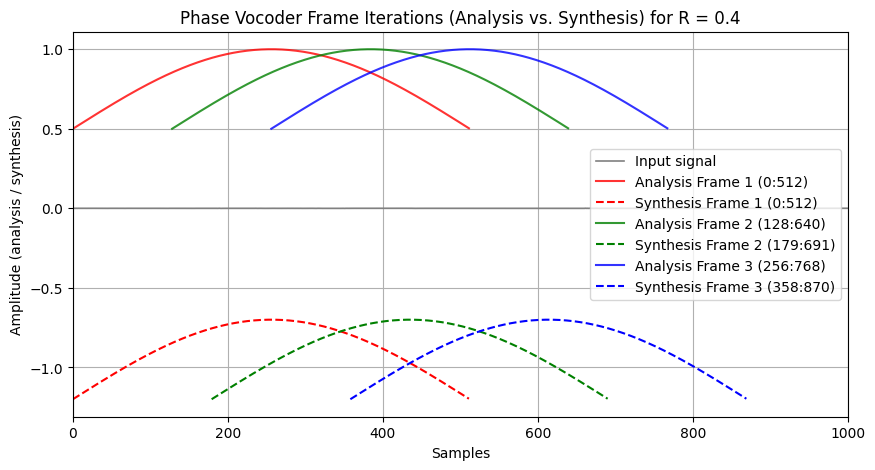

In [159]:
audioOut, params = phase_vocoder(1.4, audioIn, fs)
plot_frame(audioIn, params)

In [160]:
audioOut, params = phase_vocoder(0.4, audioIn, fs)

sd.play(audioIn, fs)
sd.wait(6)
sd.play(audioOut, fs)

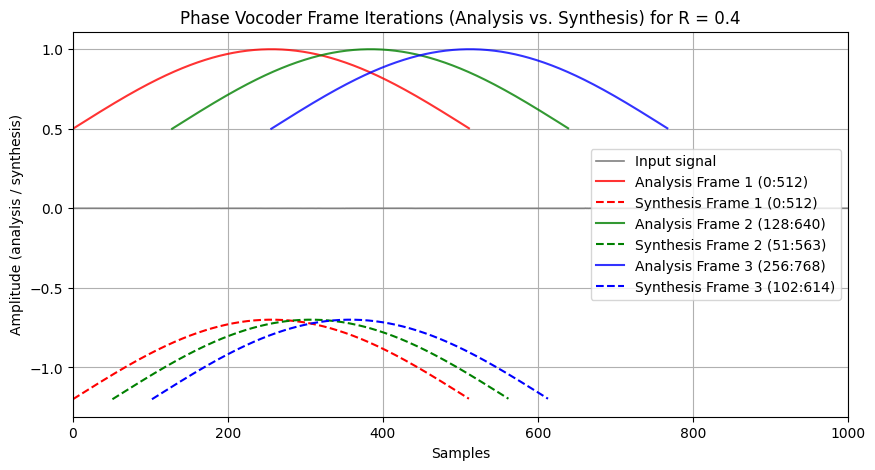

In [161]:
plot_frame(audioIn, params)

In [162]:
y, sr = librosa.load("audio.wav", sr=None)
y_fast = librosa.resample(y, orig_sr=sr, target_sr=int(1.5*sr))  # 1.5× faster
sf.write("faster.wav", y_fast, int(1.5*sr))


In [163]:
sd.play(y_fast, fs)

### Bonus question: Add pitch shifting